In [1]:
from dpks.quant_matrix import QuantMatrix

import pandas as pd
import numpy as np

In [2]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    #"/home/aaron/projects/dpks/notebooks/ml_api/covid_design_matrix.tsv",
    sep="\t"
)

In [3]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)

In [4]:
# design_matrix['group'] = np.where(
#     design_matrix['sample_num'] < 50, 3, design_matrix['group']
# )

In [5]:
design_matrix['group'].value_counts()

group
2    123
1     74
Name: count, dtype: int64

In [6]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file=design_matrix
).filter().normalize(
        method="mean",
        use_rt_sliding_window_filter=True,
        rt_unit="second",
        stride=5,
        minimum_data_points=200,
    ).quantify(method="maxlfq", top_n=5).impute(method="neighborhood")

/home/aaron/miniconda3/envs/dpks0.1.5/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/aaron/projects/dpks/dpks/dpks/quantification.py:275: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


In [7]:
qm.to_df()

,Protein,TM_P1911_190,TM_P1912_030,TM_P1912_032,TM_P1912_033,TM_P1912_034,TM_M2012_102,TM_M2012_103,TM_M2012_104,TM_M2012_106,...,TM_M2012_143,TM_M2012_127,TM_M2012_142,TM_M2012_141,TM_M2012_140,TM_M2012_138,TM_M2012_046,TM_M2012_129,TM_M2012_128,TM_M2012_041
0,P08603,24.717230,25.494552,25.141237,25.540496,24.994147,26.092043,25.672870,25.430867,25.514954,...,25.210260,25.984396,26.114732,26.122828,26.209846,26.366222,25.477740,25.747256,25.898304,25.187179
1,P02671,30.034496,28.918791,29.690906,29.121366,28.902594,27.879669,29.483051,29.911103,29.237469,...,28.064970,29.967291,28.544386,28.316590,28.004205,28.561058,29.940752,29.552427,29.593817,29.688738
2,P01042,24.481048,25.266077,24.421696,24.983738,25.214760,25.979751,25.761774,25.531679,25.605163,...,25.252370,25.945718,26.008844,26.517554,26.186563,26.208556,25.745831,25.590381,25.709089,24.962298
3,P00450,26.061303,26.612764,26.140733,26.656094,26.744928,26.456966,26.593541,26.501464,26.620184,...,25.137898,26.358820,26.201240,26.192226,25.467209,26.076142,26.793905,25.879276,26.211713,26.671304
4,P05156,23.014848,21.919844,23.398637,22.557890,22.607112,21.639420,21.801436,21.523716,22.133912,...,21.505591,23.642180,22.138601,22.583829,22.565007,23.200379,23.396516,23.209370,23.334877,22.487851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,P07333,19.759348,20.422480,19.659375,20.489971,20.294608,19.679646,19.873758,19.554750,19.405891,...,19.425559,18.920279,19.997434,18.548479,19.805635,19.404250,18.573160,18.893584,19.013321,18.037868
550,Q06323,18.681479,18.118377,18.497750,18.918493,18.401925,19.146209,18.391366,17.477954,18.067339,...,18.997520,18.072808,19.264701,18.530119,18.928317,19.837256,17.656086,17.866512,18.346884,17.651603
551,P16035,18.432887,18.516401,19.119242,18.687431,18.983767,18.320305,17.798199,18.588628,18.349684,...,19.383494,18.374109,18.270185,18.423804,19.477035,17.711620,19.744360,17.705238,17.456515,17.911868
552,O95633,17.707762,18.127397,17.755561,18.034071,17.624851,18.470644,17.704543,17.894956,17.453883,...,19.062819,16.623635,20.326704,20.444891,19.592011,19.881807,17.884090,18.095404,16.797726,17.481988


In [8]:
qm_decoys_added = qm.annotate().append(
    method="shuffle",
    feature_column="Protein"
)

In [9]:
qm_decoys_added.row_annotations.head()

,Protein,Gene,Decoy
0,P08603,CFH,0
1,P02671,FGA,0
2,P01042,KNG1,0
3,P00450,CP,0
4,P05156,CFI,0


In [10]:
qm_decoys_added.row_annotations.tail()

,Protein,Gene,Decoy
1103,decoy_P07333,decoy_CSF1R,1
1104,decoy_Q06323,decoy_PSME1,1
1105,decoy_P16035,decoy_TIMP2,1
1106,decoy_O95633,decoy_FSTL3,1
1107,decoy_O00194,decoy_RAB27B,1


In [11]:
qm_decoys_added = qm_decoys_added.compare(
    method="linregress",
    min_samples_per_group=2,
    comparisons=[(2, 1)]
)

In [12]:
qm_decoys_added.row_annotations

,Protein,Gene,Decoy,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1
0,P08603,CFH,0,0.018481,25.702930,25.733270,0.397006,0.432812,-0.030340,0.618039,123,74,0.574474,0.240730
1,P02671,FGA,0,0.037551,29.490347,29.424444,0.615070,0.795177,0.065902,0.518053,123,74,0.529300,0.276298
2,P01042,KNG1,0,0.023464,25.622400,25.583334,0.435524,0.484683,0.039066,0.561823,123,74,0.548266,0.261009
3,P00450,CP,0,0.069428,26.835505,26.728021,0.426089,0.511117,0.107484,0.115588,123,74,0.202033,0.694578
4,P05156,CFI,0,0.074842,23.281418,23.157433,0.631588,0.494956,0.123985,0.152697,123,74,0.246254,0.608617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,decoy_P07333,decoy_CSF1R,1,0.013394,19.332377,19.308489,0.714906,0.740345,0.023888,0.823805,123,74,0.664623,0.177425
1104,decoy_Q06323,decoy_PSME1,1,0.062462,18.301635,18.407716,0.643692,0.579719,-0.106081,0.248984,123,74,0.345811,0.461161
1105,decoy_P16035,decoy_TIMP2,1,0.079668,18.396142,18.532025,0.701996,0.637893,-0.135883,0.177270,123,74,0.274837,0.560924
1106,decoy_O95633,decoy_FSTL3,1,0.089920,17.470955,17.313528,0.856852,0.775616,0.157428,0.199647,123,74,0.302496,0.519281


In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

qm_decoys_added = qm_decoys_added.explain(
    clf,
    comparisons=[(2, 1)],
    n_iterations=10,
    downsample_background=True
)

In [14]:
data = qm_decoys_added.row_annotations[~qm_decoys_added.row_annotations['CorrectedPValue2-1'].isna()]

In [15]:
data

,Protein,Gene,Decoy,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,MeanImportance2-1,MeanRank2-1,MedianImportance2-1,StdevImportance2-1,MedianRank2-1,StdevRank2-1
0,P08603,CFH,0,0.018481,25.702930,25.733270,0.397006,0.432812,-0.030340,0.618039,123,74,0.574474,0.240730,0.138647,637.3,0.143442,0.069441,592.0,224.349950
1,P02671,FGA,0,0.037551,29.490347,29.424444,0.615070,0.795177,0.065902,0.518053,123,74,0.529300,0.276298,0.145243,620.5,0.147670,0.090798,561.5,259.220734
2,P01042,KNG1,0,0.023464,25.622400,25.583334,0.435524,0.484683,0.039066,0.561823,123,74,0.548266,0.261009,0.173076,556.4,0.151755,0.096111,572.5,220.951076
3,P00450,CP,0,0.069428,26.835505,26.728021,0.426089,0.511117,0.107484,0.115588,123,74,0.202033,0.694578,0.125763,679.6,0.124499,0.073805,672.0,227.828493
4,P05156,CFI,0,0.074842,23.281418,23.157433,0.631588,0.494956,0.123985,0.152697,123,74,0.246254,0.608617,0.050194,923.4,0.032446,0.045904,980.0,161.313497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,decoy_P07333,decoy_CSF1R,1,0.013394,19.332377,19.308489,0.714906,0.740345,0.023888,0.823805,123,74,0.664623,0.177425,0.073445,842.7,0.059208,0.062420,892.5,210.974485
1104,decoy_Q06323,decoy_PSME1,1,0.062462,18.301635,18.407716,0.643692,0.579719,-0.106081,0.248984,123,74,0.345811,0.461161,0.147593,633.0,0.147900,0.101309,579.5,295.596196
1105,decoy_P16035,decoy_TIMP2,1,0.079668,18.396142,18.532025,0.701996,0.637893,-0.135883,0.177270,123,74,0.274837,0.560924,0.246778,474.0,0.213792,0.186068,394.0,375.144120
1106,decoy_O95633,decoy_FSTL3,1,0.089920,17.470955,17.313528,0.856852,0.775616,0.157428,0.199647,123,74,0.302496,0.519281,0.158140,616.4,0.113590,0.122096,677.5,323.883106


<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

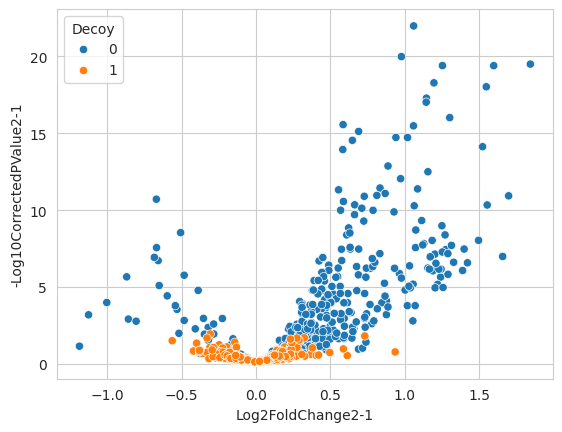

In [16]:
import seaborn as sns


sns.scatterplot(
    data=data,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1",
    hue="Decoy"
)

<Axes: xlabel='MeanImportance2-1', ylabel='Count'>

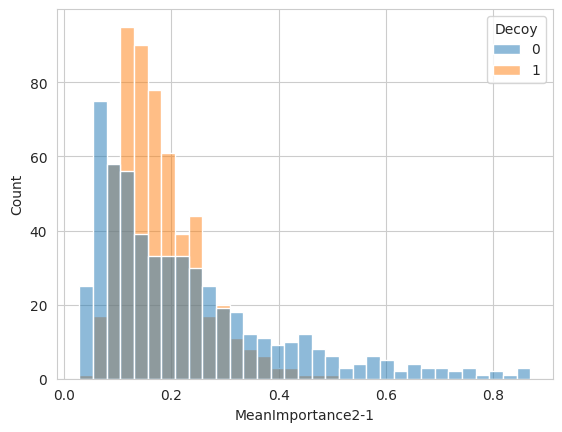

In [17]:
sns.histplot(
    data=data,
    x="MeanImportance2-1",
    #y="-Log10CorrectedPValue2-1",
    hue="Decoy"
)

In [18]:
clf = LogisticRegression()

qm_decoys_added = qm_decoys_added.evaluate(
    clf,
    comparisons=[(2, 1)],
    method="ml"
)

qm_decoys_added = qm_decoys_added.evaluate(
    clf,
    comparisons=[(2, 1)],
    method="deg"
)

qm_decoys_added = qm_decoys_added.evaluate(
    clf,
    comparisons=[(2, 1)],
    method="all"
)

qm_decoys_added = qm_decoys_added.evaluate(
    clf,
    comparisons=[(2, 1)],
    method="test_1",
    base_score_columns=[
        "DEScore",
        "CorrectedPValue",
        "Log2FoldChange",
        "MeanImportance",
        "MedianImportance"
    ]
)

In [19]:
qm_decoys_added.row_annotations

,Protein,Gene,Decoy,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,...,MedianRank2-1,StdevRank2-1,MlFeatureScore2-1,MlFeatureQValue2-1,DegFeatureScore2-1,DegFeatureQValue2-1,AllFeatureScore2-1,AllFeatureQValue2-1,Test_1FeatureScore2-1,Test_1FeatureQValue2-1
0,P08603,CFH,0,0.018481,25.702930,25.733270,0.397006,0.432812,-0.030340,0.618039,...,592.0,224.349950,-0.170927,0.364329,-0.745470,0.246468,-0.626293,0.227425,-1.529623,0.423973
1,P02671,FGA,0,0.037551,29.490347,29.424444,0.615070,0.795177,0.065902,0.518053,...,561.5,259.220734,-0.317529,0.414868,-0.060116,0.141684,0.074576,0.110638,-1.095585,0.343324
2,P01042,KNG1,0,0.023464,25.622400,25.583334,0.435524,0.484683,0.039066,0.561823,...,572.5,220.951076,-0.329113,0.422535,-0.480359,0.206597,-0.472926,0.195035,-1.536958,0.426049
3,P00450,CP,0,0.069428,26.835505,26.728021,0.426089,0.511117,0.107484,0.115588,...,672.0,227.828493,-0.047395,0.312629,0.818339,0.058824,1.059822,0.030986,0.139089,0.129386
4,P05156,CFI,0,0.074842,23.281418,23.157433,0.631588,0.494956,0.123985,0.152697,...,980.0,161.313497,0.045374,0.276423,-0.142637,0.147705,0.286380,0.082569,0.080421,0.141935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,decoy_P07333,decoy_CSF1R,1,0.013394,19.332377,19.308489,0.714906,0.740345,0.023888,0.823805,...,892.5,210.974485,0.212089,0.261905,-1.646848,0.426390,-1.275222,0.369811,-1.598109,0.434125
1104,decoy_Q06323,decoy_PSME1,1,0.062462,18.301635,18.407716,0.643692,0.579719,-0.106081,0.248984,...,579.5,295.596196,-0.240845,0.389853,-1.201555,0.341055,-1.061080,0.320548,-0.559288,0.258883
1105,decoy_P16035,decoy_TIMP2,1,0.079668,18.396142,18.532025,0.701996,0.637893,-0.135883,0.177270,...,394.0,375.144120,-0.858142,0.491713,-1.056060,0.315143,-1.116467,0.331536,-0.840217,0.300604
1106,decoy_O95633,decoy_FSTL3,1,0.089920,17.470955,17.313528,0.856852,0.775616,0.157428,0.199647,...,677.5,323.883106,-0.680439,0.483506,-0.405929,0.197133,-0.438570,0.182310,-0.219045,0.188350


<Axes: xlabel='AllFeatureScore2-1', ylabel='Count'>

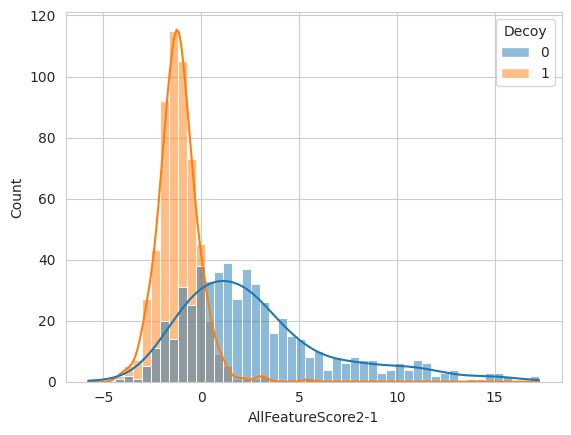

In [20]:
sns.histplot(
    data=qm_decoys_added.row_annotations,
    x="AllFeatureScore2-1",
    hue="Decoy",
    bins=50,
    kde=True
)

<Axes: xlabel='DegFeatureScore2-1', ylabel='Count'>

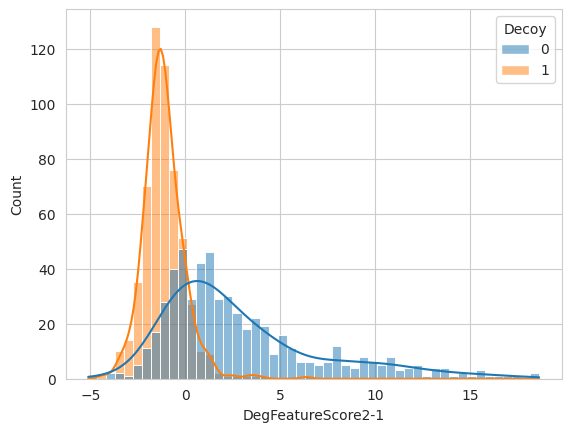

In [21]:
sns.histplot(
    data=qm_decoys_added.row_annotations,
    x="DegFeatureScore2-1",
    hue="Decoy",
    bins=50,
    kde=True
)


<Axes: xlabel='MlFeatureScore2-1', ylabel='Count'>

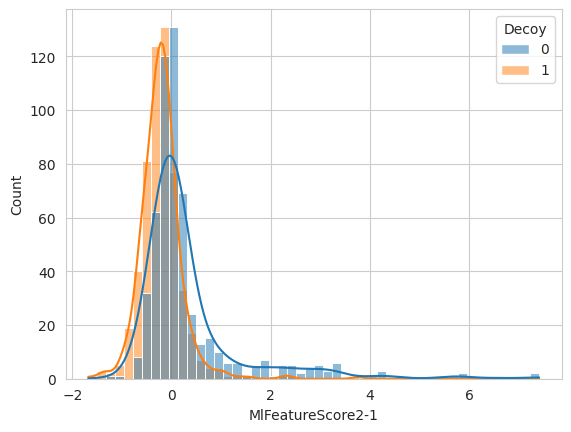

In [22]:
sns.histplot(
    data=qm_decoys_added.row_annotations,
    x="MlFeatureScore2-1",
    hue="Decoy",
    bins=50,
    kde=True
)

In [23]:
qm_decoys_added.row_annotations[qm_decoys_added.row_annotations['MlFeatureQValue2-1'] < 0.01].sort_values(
    "MlFeatureScore2-1", ascending = False
)

,Protein,Gene,Decoy,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,...,MedianRank2-1,StdevRank2-1,MlFeatureScore2-1,MlFeatureQValue2-1,DegFeatureScore2-1,DegFeatureQValue2-1,AllFeatureScore2-1,AllFeatureQValue2-1,Test_1FeatureScore2-1,Test_1FeatureQValue2-1
425,P01880,IGHD,0,0.486521,20.504984,21.362061,1.460103,1.723031,-0.857077,2.744201e-04,...,4.5,8.148620,7.414374,0.0,2.478012,0.021739,2.672994,0.017699,0.931726,0.061281
399,Q8N6C8,LILRA3,0,0.982994,19.196981,18.053445,0.813582,0.668608,1.143536,1.095656e-19,...,7.5,20.051046,7.366524,0.0,14.759160,0.000000,14.047066,0.000000,8.836201,0.000000
147,P08571,CD14,0,1.051167,21.900222,20.923072,0.644745,0.457096,0.977151,2.686496e-23,...,5.5,11.804425,6.593265,0.0,13.453648,0.000000,12.666824,0.000000,8.167331,0.000000
41,P06727,APOA4,0,0.743395,25.263452,24.200472,0.895952,1.053316,1.062980,2.159639e-12,...,3.5,12.991023,5.924593,0.0,10.826318,0.000000,9.978287,0.000000,6.038136,0.000000
151,P16070,CD44,0,1.153378,20.519783,19.460412,0.619233,0.539891,1.059371,1.363022e-25,...,6.5,9.299940,5.795110,0.0,15.098003,0.000000,14.303028,0.000000,8.860750,0.000000
257,Q06141,REG3A,0,0.155107,19.259174,19.531729,0.907635,1.150334,-0.272555,6.836193e-02,...,4.5,13.381579,5.687101,0.0,0.087340,0.118421,-2.195834,0.471400,-1.480840,0.415909
395,P14151,SELL,0,0.775815,20.236783,19.547093,0.468884,0.534901,0.689690,1.260723e-17,...,12.0,14.114217,5.527642,0.0,11.849910,0.000000,11.331054,0.000000,6.081674,0.000000
182,Q9NZP8,C1RL,0,0.768950,21.413118,20.827834,0.384381,0.454062,0.585284,3.853102e-18,...,9.5,3.977716,4.610033,0.0,10.154539,0.000000,9.471424,0.000000,5.161149,0.000000
39,Q04756,HGFAC,0,0.308345,19.627533,20.015614,0.553936,0.518667,-0.388082,2.501448e-06,...,15.0,10.403525,4.285651,0.0,1.431275,0.029703,0.944787,0.035714,0.085055,0.142241
161,P61769,B2M,0,1.105686,22.896226,21.643418,0.692723,0.872877,1.252808,2.059556e-22,...,18.0,36.474649,4.213710,0.0,15.753410,0.000000,15.002863,0.000000,9.234828,0.000000


In [24]:
qm_decoys_added.row_annotations[qm_decoys_added.row_annotations['DegFeatureQValue2-1'] < 0.01].sort_values(
    "DegFeatureScore2-1", ascending = False
)

,Protein,Gene,Decoy,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,...,MedianRank2-1,StdevRank2-1,MlFeatureScore2-1,MlFeatureQValue2-1,DegFeatureScore2-1,DegFeatureQValue2-1,AllFeatureScore2-1,AllFeatureQValue2-1,Test_1FeatureScore2-1,Test_1FeatureQValue2-1
402,P04211,IGLV7-43,0,1.047239,23.261104,21.563617,1.282014,1.747921,1.697487,3.977974e-13,...,84.5,43.397901,1.685218,0.053571,18.625915,0.000000,17.278415,0.000000,10.545769,0.000000
387,P01742,IGHV1-69,0,0.892665,25.216043,23.720552,1.065752,2.119870,1.495491,5.508464e-10,...,327.0,157.207047,-0.079284,0.322581,18.160157,0.000000,17.230275,0.000000,9.263657,0.000000
231,P59665,DEFA1,0,1.332764,23.165443,21.322102,1.244589,0.869829,1.843341,1.236229e-22,...,21.0,8.366600,3.337203,0.058824,17.489813,0.000000,15.633187,0.000000,10.573638,0.000000
437,P01614,IGKV2D-40,0,0.965753,24.538297,22.984959,1.270695,1.580940,1.553338,1.857517e-12,...,121.0,36.265839,0.709551,0.132075,16.729642,0.000000,15.440615,0.000000,9.406013,0.000000
459,P80188,LCN2,0,1.041823,21.299720,19.777367,1.177417,1.073317,1.522353,1.614888e-16,...,24.5,22.072859,2.950335,0.040000,16.369310,0.000000,15.219337,0.000000,9.403981,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,O75594,PGLYRP1,0,0.371719,17.915280,17.456930,0.598773,0.507815,0.458349,1.347121e-07,...,165.5,148.740228,0.861384,0.109890,4.068250,0.006452,3.517378,0.005848,2.939905,0.016949
447,P35030,PRSS3,0,0.269576,18.316099,17.952710,0.533377,0.629274,0.363389,2.678842e-05,...,948.0,314.670004,-0.367220,0.432584,4.039859,0.006410,4.416459,0.007246,2.207041,0.026667
267,P30086,PEBP1,0,0.364488,18.735221,18.224916,0.709869,0.656144,0.510305,1.272317e-06,...,847.5,205.524505,-0.077146,0.323810,4.031279,0.006369,4.720840,0.007752,3.354734,0.020134
42,P04114,APOB,0,0.294391,24.883669,24.426292,0.753083,0.837187,0.457377,1.149507e-04,...,60.5,59.976755,2.341454,0.054054,4.018098,0.006329,3.462291,0.005714,2.456094,0.019417


In [25]:
qm_decoys_added.row_annotations[qm_decoys_added.row_annotations['AllFeatureQValue2-1'] < 0.01].sort_values(
    "AllFeatureScore2-1", ascending=False
)

,Protein,Gene,Decoy,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,...,MedianRank2-1,StdevRank2-1,MlFeatureScore2-1,MlFeatureQValue2-1,DegFeatureScore2-1,DegFeatureQValue2-1,AllFeatureScore2-1,AllFeatureQValue2-1,Test_1FeatureScore2-1,Test_1FeatureQValue2-1
402,P04211,IGLV7-43,0,1.047239,23.261104,21.563617,1.282014,1.747921,1.697487,3.977974e-13,...,84.5,43.397901,1.685218,0.053571,18.625915,0.000000,17.278415,0.000000,10.545769,0.000000
387,P01742,IGHV1-69,0,0.892665,25.216043,23.720552,1.065752,2.119870,1.495491,5.508464e-10,...,327.0,157.207047,-0.079284,0.322581,18.160157,0.000000,17.230275,0.000000,9.263657,0.000000
231,P59665,DEFA1,0,1.332764,23.165443,21.322102,1.244589,0.869829,1.843341,1.236229e-22,...,21.0,8.366600,3.337203,0.058824,17.489813,0.000000,15.633187,0.000000,10.573638,0.000000
437,P01614,IGKV2D-40,0,0.965753,24.538297,22.984959,1.270695,1.580940,1.553338,1.857517e-12,...,121.0,36.265839,0.709551,0.132075,16.729642,0.000000,15.440615,0.000000,9.406013,0.000000
459,P80188,LCN2,0,1.041823,21.299720,19.777367,1.177417,1.073317,1.522353,1.614888e-16,...,24.5,22.072859,2.950335,0.040000,16.369310,0.000000,15.219337,0.000000,9.403981,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,P27930,IL1R2,0,0.266299,19.563438,19.113457,0.936356,1.056664,0.449981,2.258759e-03,...,380.0,205.319291,-0.280975,0.406053,3.783523,0.011976,3.359895,0.005525,2.737223,0.016043
18,P00751,CFB,0,0.206996,26.015466,25.719176,0.445415,0.735839,0.296290,5.712524e-04,...,243.0,121.389181,0.571346,0.147541,3.610997,0.011494,3.356344,0.005495,1.666147,0.036101
60,P02774,GC,0,0.231315,26.281824,25.973036,0.453115,0.633864,0.308787,1.080348e-04,...,205.0,96.102723,0.287725,0.225434,3.653640,0.011561,3.352495,0.005464,1.681514,0.032847
279,P05451,REG1A,0,0.441850,20.212217,19.433817,1.685469,1.145516,0.778400,5.836640e-04,...,789.5,229.363879,-0.182002,0.369436,3.087707,0.020202,3.286244,0.005435,4.201232,0.009901


<Axes: xlabel='AllFeatureScore2-1', ylabel='DegFeatureScore2-1'>

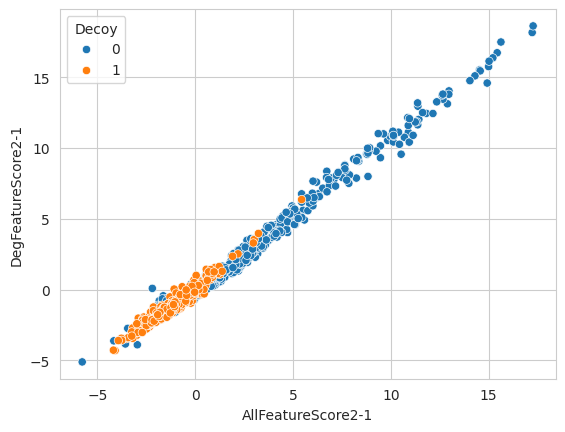

In [26]:
sns.scatterplot(
    data=qm_decoys_added.row_annotations,
    x="AllFeatureScore2-1",
    y="DegFeatureScore2-1",
    hue="Decoy",
)

<Axes: xlabel='AllFeatureScore2-1', ylabel='MlFeatureScore2-1'>

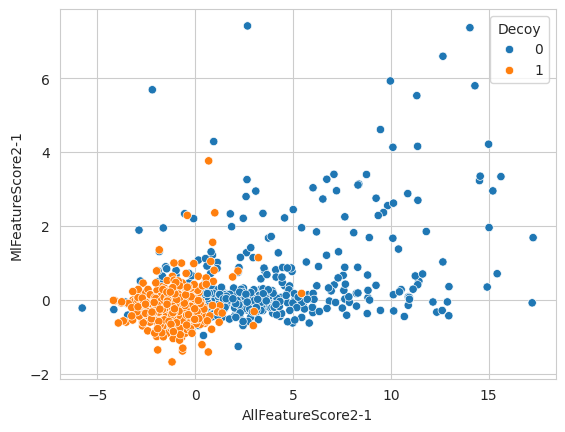

In [27]:
sns.scatterplot(
    data=qm_decoys_added.row_annotations,
    x="AllFeatureScore2-1",
    y="MlFeatureScore2-1",
    hue="Decoy",
)

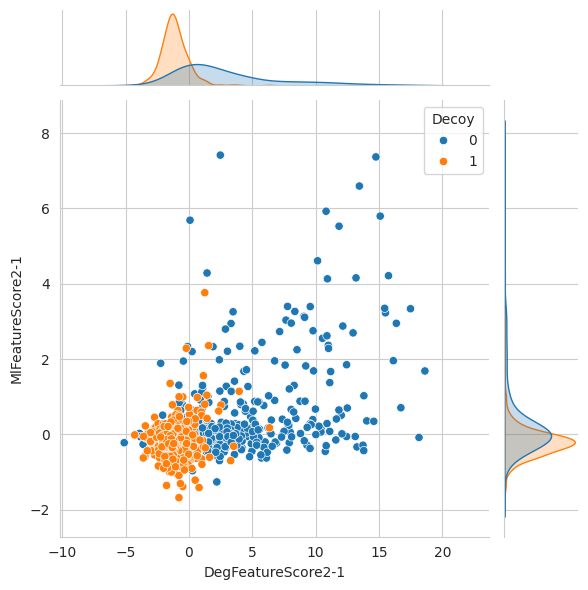

In [28]:
sns.jointplot(
    data=qm_decoys_added.row_annotations,
    x="DegFeatureScore2-1",
    y="MlFeatureScore2-1",
    hue="Decoy",
)

In [29]:
qm_decoys_added.row_annotations[
    (qm_decoys_added.row_annotations['DegFeatureQValue2-1'] < 0.01) &
    (qm_decoys_added.row_annotations['MlFeatureQValue2-1'] < 0.01)
 ].sort_values(
    "MlFeatureScore2-1", ascending=False
)

,Protein,Gene,Decoy,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,...,MedianRank2-1,StdevRank2-1,MlFeatureScore2-1,MlFeatureQValue2-1,DegFeatureScore2-1,DegFeatureQValue2-1,AllFeatureScore2-1,AllFeatureQValue2-1,Test_1FeatureScore2-1,Test_1FeatureQValue2-1
399,Q8N6C8,LILRA3,0,0.982994,19.196981,18.053445,0.813582,0.668608,1.143536,1.095656e-19,...,7.5,20.051046,7.366524,0.0,14.759160,0.0,14.047066,0.0,8.836201,0.0
147,P08571,CD14,0,1.051167,21.900222,20.923072,0.644745,0.457096,0.977151,2.686496e-23,...,5.5,11.804425,6.593265,0.0,13.453648,0.0,12.666824,0.0,8.167331,0.0
41,P06727,APOA4,0,0.743395,25.263452,24.200472,0.895952,1.053316,1.062980,2.159639e-12,...,3.5,12.991023,5.924593,0.0,10.826318,0.0,9.978287,0.0,6.038136,0.0
151,P16070,CD44,0,1.153378,20.519783,19.460412,0.619233,0.539891,1.059371,1.363022e-25,...,6.5,9.299940,5.795110,0.0,15.098003,0.0,14.303028,0.0,8.860750,0.0
395,P14151,SELL,0,0.775815,20.236783,19.547093,0.468884,0.534901,0.689690,1.260723e-17,...,12.0,14.114217,5.527642,0.0,11.849910,0.0,11.331054,0.0,6.081674,0.0
182,Q9NZP8,C1RL,0,0.768950,21.413118,20.827834,0.384381,0.454062,0.585284,3.853102e-18,...,9.5,3.977716,4.610033,0.0,10.154539,0.0,9.471424,0.0,5.161149,0.0
161,P61769,B2M,0,1.105686,22.896226,21.643418,0.692723,0.872877,1.252808,2.059556e-22,...,18.0,36.474649,4.213710,0.0,15.753410,0.0,15.002863,0.0,9.234828,0.0
234,P13611,VCAN,0,1.045516,20.256379,19.060833,0.860840,0.554742,1.195546,4.068965e-21,...,17.0,9.158481,4.155976,0.0,13.187889,0.0,11.372068,0.0,7.639717,0.0
378,P07858,CTSB,0,0.760303,19.961776,18.990002,0.879799,0.635874,0.971774,2.384631e-14,...,21.5,9.811558,4.130550,0.0,10.932253,0.0,10.108367,0.0,6.420446,0.0


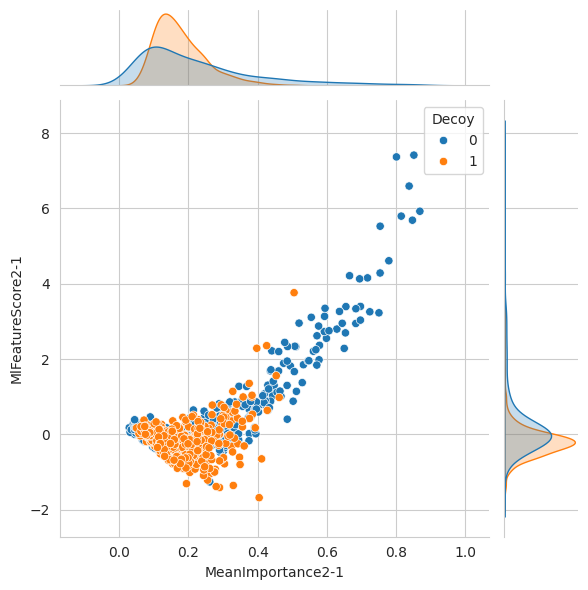

In [33]:
sns.jointplot(
    data=qm_decoys_added.row_annotations,
    x="MeanImportance2-1",
    y="MlFeatureScore2-1",
    hue="Decoy",
)

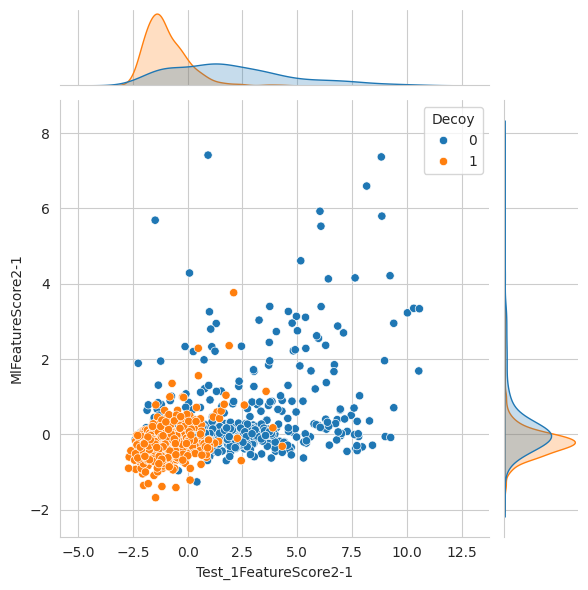

In [34]:
sns.jointplot(
    data=qm_decoys_added.row_annotations,
    x="Test_1FeatureScore2-1",
    y="MlFeatureScore2-1",
    hue="Decoy",
)

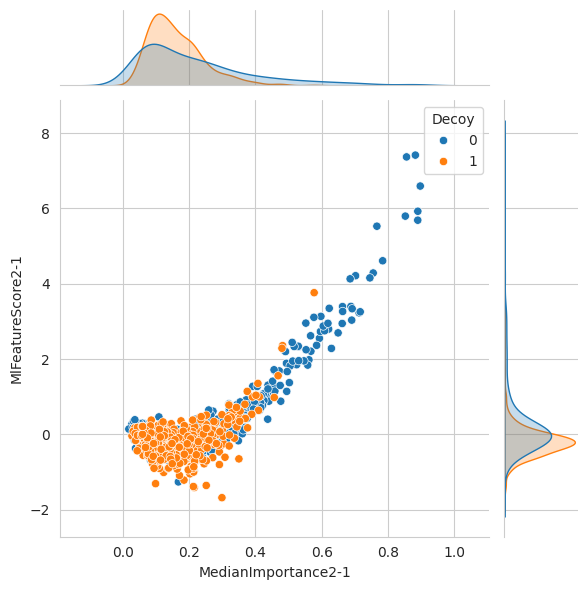

In [35]:
sns.jointplot(
    data=qm_decoys_added.row_annotations,
    x="MedianImportance2-1",
    y="MlFeatureScore2-1",
    hue="Decoy",
)